# Smooth Bilevel Programming for Sparse Regularization

This tour is a tutorial reviewing the method developped in the paper:

> _[Smooth Bilevel Programming for Sparse Regularization](https://arxiv.org/abs/2106.01429)_
Clarice Poon, Gabriel Peyré, 2021

We present a surprisingly simple reformulation of the Lasso as a bilevel program, which can be solved using efficient method such as L-BFGS. This gives an algorithm which is simple to implement and is in the same ballpark as state of the art approach when the regularization parameter $\lambda$ is small (it can in particular cope in a seamless way with the constraint formulation when $\lambda=0$). For large $\lambda$, and when the solution is very sparse, the method is not as good as for instance coordinate methods with safe screening/support pruning such as the [Celer](https://github.com/mathurinm/celer) solver which we warmly recommend.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import progressbar

# Lasso problem

We aim at solving the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) problem
$$
    \min_x \frac{1}{2\lambda}\| A x -y \|^2 + \|x\|_1. 
$$
We generate here a synthetic example using a random matrix $A \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^p$.

In [3]:
n = 10;
p = n*2;
A = np.random.randn(n,p)
y = np.random.randn(n)

The simplest (but arguably not the fastest) algorithm to solve this problem is the iterative soft thresholding
$$
    x_{k+1} = \text{Thresh}_{\tau \lambda}( y - \tau A^\top (Ax_k-y) )
$$
where the step size should satisfies $\tau < 2/\|A\|$, and Thresh is the soft thresholding
$$
    \text{Thresh}_\sigma( x ) = \text{sign}(x) \max(|x|-\sigma,0)
$$

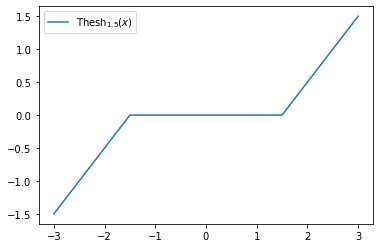

In [4]:
def Thresh(x,sigma): return np.sign(x) * np.maximum(np.abs(x)-sigma,0)
x = np.linspace(-3,3,1000)
plt.plot( x, Thresh(x,1.5), label='Thesh$_{1.5}(x)$')
plt.legend();

The critical $\lambda$ for which the solution of the Lasso is 0 is $\|A^\top y\|_\infty$. We select the $\lambda$ as a fraction of this value.

In [5]:
la = .5 * np.max( A.T @ y )

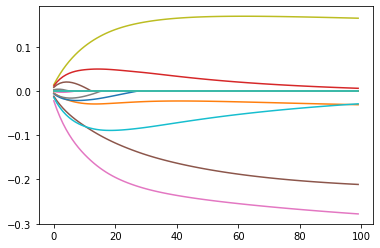

In [6]:
tau = .1/np.linalg.norm(A)
niter = 100
x = np.zeros(p)
x_ista = np.zeros((p,niter))
for it in range(niter):
    x = Thresh( x - tau*A.T @ ( A@x - y ),  tau*la )
    x_ista[:,it] = x
plt.plot(x_ista.T);

# Non-convex Variational Projection

The following variational formulation is pivotal for the developpement of our approach
$$
    \|x\|_1 = \min_{u \odot v = x} \frac{\|u\|_2^2 + \|v\|_2^2 }{2}
$$
where $u \odot v = (u_i v_i)_{i=1}^p$.

Thanks for this formula, we can minimize the Lasso problem on $(u,v)$ instead of $x$ (which corresponds to an over-parameterization of the problem). The crux of the method is that instead of doing an alternative minimization over $u$ and $v$ (which is a classical method), we rather consider a bilevel formulation

$$
    \min_{v} f(v)    
     \quad
     \text{where}
     \quad
    f(v) = \min_{u}  F(u,v) \triangleq \frac{1}{2 \lambda}\| A(u \odot v) - y \|^2
    + \frac{\|u\|_2^2 + \|v\|_2^2 }{2} 
$$
The effect of this bilevel formulation is to make the function $f$ better conditionned (and in particular smooth) than the original Lasso functional. 


For a given $v$, the optimal $u$ solving the inner problem $\min_u F(u,v)$ is unique and can be found by solving a linear system
$$
    u^\star(v) = ( \text{diag}(v) A^\top A \text{diag}(v) + \lambda \text{Id}_p )^{-1} ( v \odot A^\top y ) 
$$

In [7]:
def u_opt1(v): 
    T = np.diag(v)@(A.T@A)@np.diag(v) + la * np.eye(p)
    return np.linalg.solve( T, v * (A.T@y) )

Using [Sherman–Morrison](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula), this equivalently reads
$$
    u^\star(v) = v \odot A^\top ( A \text{diag}(v^2) A^\top + \lambda \text{Id}_n )^{-1} y.
$$
This formula is more efficient when $p>n$ (which is the case here).

In [8]:
def u_opt(v): 
    S = A@np.diag(v**2)@A.T  + la * np.eye(n)
    return v * ( A.T @ np.linalg.solve( S, y ) )

Compare the two formula.

In [9]:
v = np.random.randn(p)
print( "Should be 0: " + str( np.linalg.norm(u_opt1(v)-u_opt(v)) ) ) 

Should be 0: 1.46716718516912e-15


According to the [envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem), the function $f$ is thus differentiable and its gradient reads
$$
    \nabla f(v) = \nabla_v F(u^\star(v),v)
      = 
     \frac{1}{\lambda} u^\star \odot A^\top ( A (u^\star \odot v) - y ) + v
$$

In [10]:
def nabla_f(v):
    u = u_opt(v)
    f = 1/(2*la) * np.linalg.norm( A@(u*v) - y )**2 + \
        ( np.linalg.norm(u)**2 + np.linalg.norm(v)**2 )/2
    g = u * ( A.T@( A@(u*v)-y ) ) / la + v
    return f, g

Test using finite difference that the formula is correct
$$
    \frac{f(v+t \delta) - f(v)}{t} \approx \langle \nabla f(v), \delta \rangle
$$

In [11]:
t = 1e-6
delta = np.random.randn(p)
f,g = nabla_f(v)
f1,g1 = nabla_f(v+t*delta)
d1 = ( f1-f ) / t
d2 = np.sum( delta*g )
print( "Should be small: " + str( (d1-d2)/d1 ) )

Should be small: 2.0526767984902404e-06


We implement a simple [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
$$
    v_{k+1} = v_k - \tau \nabla f(v_k)
$$
and display the evolution of $x_k = u^\star(v_k) \odot v_k$.

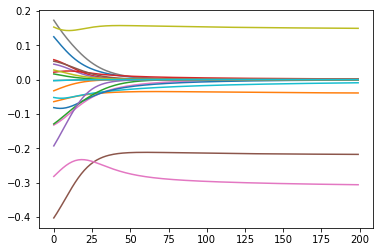

In [12]:
tau = .05
niter = 200
x_pro = np.zeros((p,niter))
v = np.random.randn(p)
for it in range(niter):
    f,g = nabla_f(v)
    v = v - tau*g
    x_pro[:,it] = v * u_opt(v)
plt.plot(x_pro.T);

While the trajectory of ISTA are piecewise smooth, and are not differentiable when crossing 0, the trajectory of this bilevel method can smoothly cross or approach 0. 

# Non-convex Pro method: using BFGS

One can show that $f$ is a smooth function. Although it is non-convex, it has no spurious local minima and its saddle points (such as $v=0$) are "ridable" (aka strict saddle), so that trajectory of descent method are not blocked as such saddle points.

Loading a dataset from LibSVM. In some cases, the $A$ matrix is sparse.

In [14]:
name = 'w8a'
name = 'connect-4'
name = 'mnist'
from libsvmdata import fetch_libsvm
A,y = fetch_libsvm(name)
n,p = A.shape
print('n=' + str(n) + ', p=' + str(p))

Dataset: mnist
n=60000, p=683


For the sake of simplicity, we conver the matrix to a dense one (but the method can take advantage of sparse matrices). We also normalize the matrix to zero mean and unit norm columns.

In [15]:
import scipy
if scipy.sparse.issparse(A):
    A = A.todense()
A = np.array(A)
A = A - A.mean(axis=0)
A = A / A.std(axis=0)
y = y-y.mean()

We select $\lambda$ as a fraction of $\|A^\top y\|_\infty$.

In [16]:
la = .1 * np.max( A.T @ y )

Then re-define the function computing $\nabla f$, select the most efficient formula to compute $u^\star(v)$.

In [17]:
def u_opt(v): 
    S = A@np.diag(v**2)@A.T  + la * np.eye(n)
    return v * ( A.T @ np.linalg.solve( S, y ) )
def nabla_f(v):
    u = u_opt(v)
    f = 1/(2*la) * np.linalg.norm( A@(u*v) - y )**2 + \
        ( np.linalg.norm(u)**2 + np.linalg.norm(v)**2 )/2
    g = u * ( A.T@( A@(u*v)-y ) ) / la + v
    return f, g

Denoting $C \triangleq A^\top A \in \mathbb{R}^{p \times p}$ the correlation matrix and $h \triangleq A^\top y \in \mathbb{R}^p$, since
$$
    \|Ax-y\|^2 = \langle Cx,x \rangle + \langle y,y \rangle - 2 \langle x,h \rangle
$$
the Lasso problem only depends on $C$ and $h$.
When $n>p$, it is faster to implement the solver in these variables.

In [18]:
C = A.T@A
ATy = A.T@y
y2 = np.inner(y,y) # bug 
if scipy.sparse.issparse(C):
    C = C.todense()
C = np.array(C)
def u_opt_cov(v):         
    T = v[:,None]*v[None,:]*C  + la * np.eye(p)
    return np.linalg.solve( T, v * ATy )
def nabla_f_cov(v):
    u = u_opt(v)
    x = u*v
    E = np.inner(C@x,x) + y2 - 2*np.inner(x,ATy);
    f = 1/(2*la) * E + \
        ( np.linalg.norm(u)**2 + np.linalg.norm(v)**2 )/2
    g = u * ( C@x-ATy  ) / la + v
    return f, g

In [19]:
if n<200 & p<200:
    v = np.random.randn(p)
    f1,g1 = nabla_f(v)
    f2,g2 = nabla_f_cov(v)
    print('Should be 0: ' + str(f1-f2))
    print('Should be 0: ' + str(np.linalg.norm(g1-g2)))

In [20]:
if p<n:
    print('p<n, using covariance mode')
    u_opt   = u_opt_cov
    nabla_f = nabla_f_cov
else:
    print('p>n, using full mode')

p<n, using covariance mode


In order to obtain an efficient numerical scheme, one should use a quasi-Newton [L-BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).
The option `maxcor` controls the size of the memory.

In [21]:
# callback to store intermediate results
flist = [];
tlist = [];
t0 = time.time()
def callback(v):
    f,g = nabla_f(v)
    flist.append(f)
    tlist.append(time.time()-t0)
    return f,g
# run L-BFGS
import scipy.optimize
v0 = np.random.randn(p)
opts = { 'gtol': 1e-30, 'maxiter':1000, 'maxcor': 10, 'ftol': 1e-30, 'maxfun':10000 }
R = scipy.optimize.minimize(callback, v0, method='L-BFGS-B', jac=True, tol=1e-30, options=opts)
# retrieve optimal solution 
v = R.x
x_pro = v * u_opt(v)

<ipython-input-22-22513bec622e>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(tlist, np.log10( flist - fstar ) )


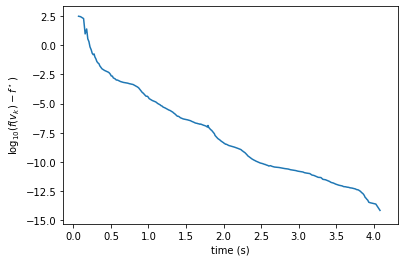

In [22]:
tlist = np.array(tlist)
flist = np.array(flist)
fstar = np.min(flist)
plt.plot(tlist, np.log10( flist - fstar ) )
plt.xlabel("time (s)")
plt.ylabel("$\log_{10}(f(v_k)-f^\star)$");

Sparsity: 12%


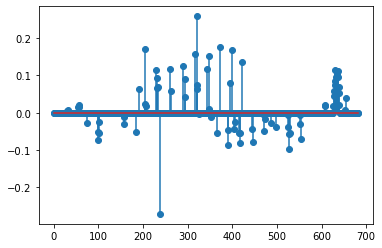

In [23]:
plt.stem(x_pro)
s = np.sum( np.abs(x_pro)>1e-3 )
print('Sparsity: ' + str( (s/p*100).astype(int) )  + '%' )

We compare agains [Celer](https://github.com/mathurinm/celer)'s algorithm. Note that this algorithm is very efficient (more efficient than the bilevel method) for large $\lambda$. 

In [24]:
def lasso_func(x): return 1/(2*la) * np.linalg.norm(A@x-y)**2 + np.linalg.norm(x,1)

In [ ]:
import celer
def lasso_func(x): return 1/(2*la) * np.linalg.norm(A@x-y)**2 + np.linalg.norm(x,1)
warnings.filterwarnings("ignore")
m = 10;
niter_list = np.linspace(1,20,m).astype(int)
tlist_celer = np.zeros(m)
flist_celer = np.zeros(m)
for i in progressbar.progressbar(range(m)):
    niter = niter_list[i]
    t0 = time.time()
    x_celer = celer.Lasso(alpha = la/n, verbose=False,fit_intercept=False, max_iter=niter, tol=1e-20).fit(A,y).coef_.T        
    tlist_celer[i] = time.time()-t0
    flist_celer[i] = lasso_func(x_celer)

 10% (1 of 10) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:04

In [ ]:
fstar = min( np.min(flist_celer),np.min(flist) )
tmax = np.Inf
plt.plot(tlist[tlist<tmax], np.log10( flist[tlist<tmax] - fstar ), label='NonCvx-Pro' )
plt.plot(tlist_celer, np.log10( flist_celer - fstar ), label='Celer' )
plt.legend();
plt.xlabel("time (s)")
plt.ylabel("$\log_{10}(f(v_k)-f^\star)$");